In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import os
import numpy as np

import cv2

plt.style.use('ggplot')


In [2]:

#CNN Model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1st layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2d layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# dense 
model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])

In [3]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')


In [10]:
img = load_img('TestAnimal/nounou2.jpg') # this is a PIL image
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
print(x.shape)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='data/preview', save_prefix='nounou', save_format='jpeg'):
  i += 1
  if i > 20:
    break # otherwise the generator would loop indefinitely

(1512, 2016, 3)
(1, 1512, 2016, 3)


In [4]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

In [7]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
'./data/train', # this is the target directory
classes = ["rabbit","dog"],
target_size=(150, 150), # all images will be resized to 150x150
batch_size=batch_size,
class_mode='binary')

Found 851 images belonging to 2 classes.


In [8]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
'./data/validation',
classes = ["rabbit","dog"],
target_size=(150, 150),
batch_size=batch_size,
class_mode='binary')

Found 201 images belonging to 2 classes.


In [9]:
from keras.backend import clear_session
clear_session()

history = model.fit_generator(
train_generator,
#steps_per_epoch= 2 , # // batch_size,
epochs=50,
validation_data=validation_generator,
#validation_steps= 2 
) # // batch_size)
model.save_weights('data/first_try.h5') # always save your weights after training or during training

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
54/54 [==============================] - 37s 615ms/step - loss: 0.7361 - accuracy: 0.5415 - val_loss: 0.5949 - val_accuracy: 0.6517
Epoch 2/50
54/54 [==============================] - 34s 619ms/step - loss: 0.6588 - accuracy: 0.6612 - val_loss: 0.5087 - val_accuracy: 0.7960
Epoch 3/50
54/54 [==============================] - 34s 622ms/step - loss: 0.6039 - accuracy: 0.7375 - val_loss: 0.5354 - val_accuracy: 0.7512
Epoch 4/50
54/54 [==============================] - 33s 614ms/step - loss: 0.5702 - accuracy: 0.7251 - val_loss: 0.5165 - val_accuracy: 0.7861
Epoch 5/50
54/54 [==============================] - 34s 635ms/step - loss: 0.5196 - accuracy: 0.7225 - val_loss: 0.5181 - val_accuracy: 0.7313
Epoch 6/50
54/54 [==============================] - 33s 618ms/step - loss: 0.5138 - accuracy: 0.7564 - val_loss: 0.5420 - val_accuracy: 0.7662
Epoch 7/50
54/54 [==============================] - 34s 617ms/step - loss: 0.4504 - accuracy: 0.7876 - val_loss: 0.4383 - val_accuracy: 0.8159

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


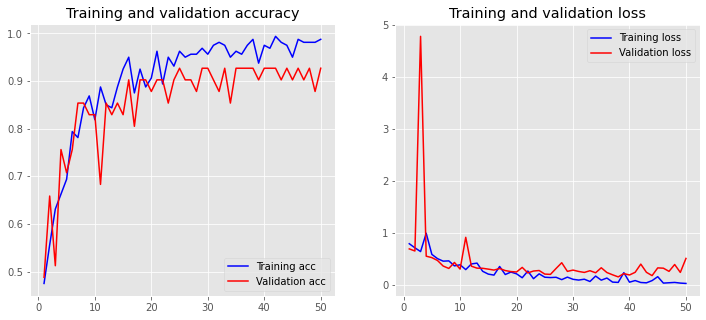

In [17]:
plot_history(history)

In [18]:
#import keras
#from keras.models import load_model
#from keras.models import Sequential
import cv2
import numpy as np 

img = cv2.imread('TestAnimal/rabbit1.jpeg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict_classes(img)
print(classes)

[[0]]


/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
validation_generator.class_indices

{'rabbit': 0, 'dog': 1}

In [20]:
img = cv2.imread('TestAnimal/nounou2.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict_classes(img)
print(classes)

[[0]]


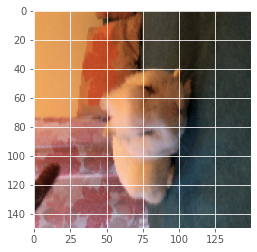

In [21]:
img1 = load_img('TestAnimal/nounou2.jpg', target_size=(150, 150))
#img = cv2.resize(img,(150,150))
plt.imshow(img1)

In [16]:
## Model m

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [17]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

In [18]:

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
'./data/train', # this is the target directory
classes = ["cat","dog","rabbit"],
target_size=(150, 150), # all images will be resized to 150x150
batch_size=batch_size)
#,class_mode='binary')

Found 240 images belonging to 3 classes.


In [10]:
#train_generator.labels

In [20]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'rabbit': 2}

In [73]:
validation_generator.class_indices
labels = {v : k for k , v in train_generator.class_indices.items()}
labels[2]

'rabbit'

In [22]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
'./data/validation',
classes = ["cat","dog","rabbit"],
target_size=(150, 150),
batch_size=batch_size)
#,class_mode='categorical')

Found 61 images belonging to 3 classes.


In [38]:
clear_session()
history = model.fit_generator(
train_generator,
#steps_per_epoch= 2 , # // batch_size,
epochs=50,
validation_data=validation_generator,
#validation_steps= 2 
) # // batch_size)
#model.save_weights('drive/MyDrive/sample_data/first_try.h5') # always save your weights after training or during training

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
15/15 [==============================] - 6s 328ms/step - loss: 1.8748 - accuracy: 0.3138 - val_loss: 1.0809 - val_accuracy: 0.3770
Epoch 2/50
15/15 [==============================] - 5s 292ms/step - loss: 1.0891 - accuracy: 0.4389 - val_loss: 1.0871 - val_accuracy: 0.4426
Epoch 3/50
15/15 [==============================] - 5s 328ms/step - loss: 1.1007 - accuracy: 0.3763 - val_loss: 1.0277 - val_accuracy: 0.6066
Epoch 4/50
15/15 [==============================] - 5s 308ms/step - loss: 1.0656 - accuracy: 0.4798 - val_loss: 1.0631 - val_accuracy: 0.3607
Epoch 5/50
15/15 [==============================] - 5s 334ms/step - loss: 1.0239 - accuracy: 0.5747 - val_loss: 1.0441 - val_accuracy: 0.3934
Epoch 6/50
15/15 [==============================] - 5s 312ms/step - loss: 0.9614 - accuracy: 0.5022 - val_loss: 0.9165 - val_accuracy: 0.5410
Epoch 7/50
15/15 [==============================] - 5s 297ms/step - loss: 0.8491 - accuracy: 0.6409 - val_loss: 0.9422 - val_accuracy: 0.4918
Epoch 

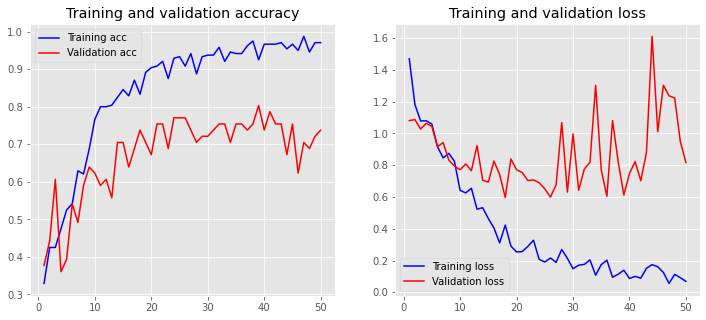

In [39]:
plot_history(history)

In [23]:
train_generator.class_indices
validation_generator.class_indices


{'cat': 0, 'dog': 1, 'rabbit': 2}

In [24]:
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples


61

In [42]:
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
    
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['cat', 'dog', 'rabbit']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[10  6  4]
 [ 9  5  7]
 [ 8  8  4]]
Classification Report
              precision    recall  f1-score   support

         cat       0.37      0.50      0.43        20
         dog       0.26      0.24      0.25        21
      rabbit       0.27      0.20      0.23        20

    accuracy                           0.31        61
   macro avg       0.30      0.31      0.30        61
weighted avg       0.30      0.31      0.30        61



In [43]:
y_pred

array([2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 0,
       2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0])

In [44]:
img = cv2.imread('TestAnimal/nounou2.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict_classes(img)
print(classes)

[2]


/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [71]:
def predict_label(img, model):
    img = cv2.imread(img)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])
    classes = model.predict_classes(img)
    return labels[classes[0]]
    

In [46]:
predict_label("TestAnimal/nounou2.jpg", model)

'rabbit'

In [47]:
predict_label("TestAnimal/nounou4.jpg", model)  

'rabbit'

In [58]:
predict_label("TestAnimal/cat872a.jpg", model)  

'cat'

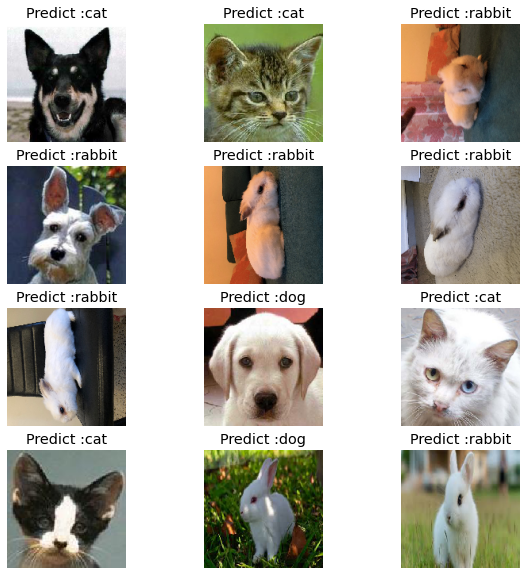

In [48]:
import matplotlib.pyplot as plt
import os

# Get list of animal in the folder

current_path = "TestAnimal"
list_animal=[] 
for file in os.listdir(current_path):
    list_animal.append(file)
#print (list_animal)


plt.figure(figsize=(10, 10))
for i, image in enumerate(list_animal):
    ax = plt.subplot(4, 3, i +1)
    path = "TestAnimal/" + image
    
    y_pred = predict_label(path, model)   
    img1 = load_img(path, target_size=(150, 150))
    plt.imshow(img1)
    label = "Predict :" + y_pred
    plt.title(label)
    plt.axis("off")
    


### RandomizedSearchCV

In [15]:
batch_size = 16


datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [16]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
'data/train', # this is the target directory
classes = ["cat","dog","rabbit"],
target_size=(150, 150), # all images will be resized to 150x150
batch_size=batch_size)
#,class_mode='binary')

Found 1262 images belonging to 3 classes.


In [33]:
print(train_generator.samples)
print(validation_generator.samples)

1262
300


In [63]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
'data/validation',
classes = ["cat","dog","rabbit"],
target_size=(150, 150),
batch_size=batch_size)


Found 61 images belonging to 3 classes.


In [64]:

X_train, y_train = train_generator.next()


In [65]:
X_train.shape

(16, 150, 150, 3)

In [24]:
def create_model(num_filters,num_filters1, kernel_size, dropout, optimizer):
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters1, kernel_size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters1, kernel_size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
    metrics=['accuracy'])
    return model

In [67]:
param_grid = dict(num_filters=[16,32,64],
                  num_filters1= [64], 
                  kernel_size=[(3, 3)],
                  dropout = [0.3, 0.5],
                  optimizer =['RMSprop','Adam']
                  
                 )

In [71]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
clear_session()
epochs = 25

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=16,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test,y_test)
print('accuracy_test = ',test_accuracy)

print('best socre = ', grid_result.best_score_)
print('best param = ',grid_result.best_params_)



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.2min finished


accuracy_test =  0.25
best socre =  0.625
best param =  {'optimizer': 'RMSprop', 'num_filters1': 64, 'num_filters': 32, 'kernel_size': (3, 3), 'dropout': 0.3}


In [72]:
model1 = create_model(optimizer= 'RMSprop', num_filters1= 64, num_filters= 32, kernel_size = (3, 3), dropout = 0.3)


In [73]:
#clear_session()
history = model1.fit_generator(
train_generator,
steps_per_epoch= train_generator.samples// batch_size,
epochs=20,
validation_data=validation_generator,
#validation_steps= 2 
) # // batch_size)
#model.save_weights('drive/MyDrive/sample_data/first_try.h5') # always save your weights after training or during training

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 11s 625ms/step - loss: 1.4150 - accuracy: 0.3554 - val_loss: 1.3522 - val_accuracy: 0.3443
Epoch 2/20
15/15 [==============================] - 10s 641ms/step - loss: 1.1345 - accuracy: 0.3916 - val_loss: 1.1070 - val_accuracy: 0.3607
Epoch 3/20
15/15 [==============================] - 9s 601ms/step - loss: 1.0684 - accuracy: 0.5507 - val_loss: 0.9980 - val_accuracy: 0.5574
Epoch 4/20
15/15 [==============================] - 9s 572ms/step - loss: 0.9754 - accuracy: 0.5815 - val_loss: 0.9770 - val_accuracy: 0.4426
Epoch 5/20
15/15 [==============================] - 9s 594ms/step - loss: 0.8438 - accuracy: 0.6299 - val_loss: 0.9557 - val_accuracy: 0.5082
Epoch 6/20
15/15 [==============================] - 9s 626ms/step - loss: 0.7158 - accuracy: 0.6897 - val_loss: 0.9764 - val_accuracy: 0.5410
Epoch 7/20
15/15 [==============================] - 9s 606ms/step - loss: 0.6208 - accuracy: 0.7532 - val_loss: 0.8546 - val_accuracy: 0.5738
Epoc

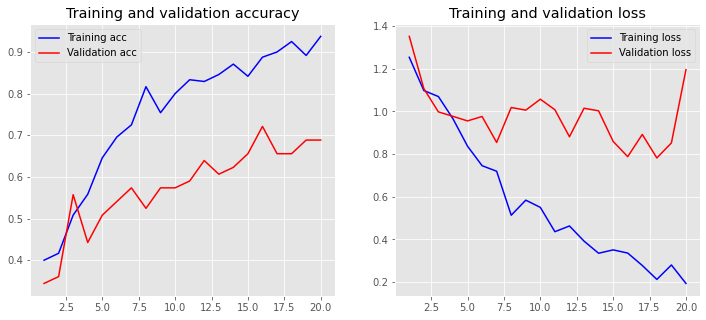

In [74]:
plot_history(history)

In [75]:
#Confution Matrix and Classification Report
Y_pred = model1.predict_generator(validation_generator, nb_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['cat', 'dog', 'rabbit']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[10  5  5]
 [ 7  7  7]
 [11  4  5]]
Classification Report
              precision    recall  f1-score   support

         cat       0.36      0.50      0.42        20
         dog       0.44      0.33      0.38        21
      rabbit       0.29      0.25      0.27        20

    accuracy                           0.36        61
   macro avg       0.36      0.36      0.36        61
weighted avg       0.36      0.36      0.36        61



In [94]:
# Augmented data
import os
#current_path = os.path.join(src, animal)
path = "data/train"
def list_file(path):
  list_file=[] 
  for file in os.listdir(path):
      list_file.append(file)
  return list_file

In [95]:
labels = list_file(path)
labels

['cat', 'rabbit', 'dog']

In [109]:
def dataAugmentation(nbr,x, path, name):
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=path, save_prefix=name, save_format='jpg'):
      i += 1
      if i > nbr:
        break # otherwise the generator would loop indefinitely

In [111]:
# Augmentation train
for label in labels :
    path = "data/train/" + label 
    list_file(path)
    for name in list_file(path):
        img = load_img(path+"/"+name)
        x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
        dataAugmentation(3,x,path, label)
        
   

cat
rabbit
dog


In [117]:
# Augmentation validation
for label in labels :
    path = "data/validation/" + label 
    list_file(path)
    for name in list_file(path):
        img = load_img(path+"/"+name)
        x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
        dataAugmentation(3,x,path, label)


In [113]:
path = "data/train/"
for name in labels :
    augmentation = len(list_file(path+name))
    print(f"nomber of {name} after augementation : {augmentation}")

nomber of cat after augementation : 411
nomber of rabbit after augementation : 427
nomber of dog after augementation : 424


In [38]:
# number of samples to validation after augmentation
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples


300

### GridSearchCV

In [18]:
batch_size = 16


datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
'data/train', # this is the target directory
classes = ["cat","dog","rabbit"],
target_size=(150, 150), # all images will be resized to 150x150
batch_size=batch_size)
#,class_mode='binary')

#train_generator.samples

Found 1262 images belonging to 3 classes.


In [19]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
'data/validation',
classes = ["cat","dog","rabbit"],
target_size=(150, 150),
batch_size=batch_size)


Found 300 images belonging to 3 classes.


In [64]:
X_train, y_train = train_generator.next()
print(f"X_train : {X_train.shape}   y_train: {X_train.shape}")

X_train : (16, 150, 150, 3)   y_train: (16, 150, 150, 3)


In [65]:
X_test, y_test = train_generator.next()
print(f"X_test : {X_test.shape}   y_train: {X_test.shape}")

X_test : (16, 150, 150, 3)   y_train: (16, 150, 150, 3)


In [30]:
param_grid = dict(num_filters=[16,32,64],
                  num_filters1= [64], 
                  kernel_size=[(3, 3)],
                  dropout = [0.3, 0.5],
                  optimizer =['RMSprop','Adam']
                  
                 )

In [ ]:
# This part was excuted in the colab
#clear_session()
epochs = 25

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=16,
                            verbose=False)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=4, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test,y_test)
print('accuracy_test = ',test_accuracy)

print('best socre = ', grid_result.best_score_)
print('best param = ',grid_result.best_params_)

In [25]:
# we have this result 
#Paramters of the best model1
model2 = create_model(optimizer= 'Adam', num_filters1= 64, num_filters= 32, kernel_size = (3, 3), dropout = 0.3)

In [26]:
clear_session()
history = model2.fit_generator(
train_generator,
#steps_per_epoch= train_generator.samples// batch_size,
epochs=20,
validation_data=validation_generator)

# always save your weights after training or during training

/home/sacia/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
79/79 [==============================] - 36s 443ms/step - loss: 1.1625 - accuracy: 0.3489 - val_loss: 1.0675 - val_accuracy: 0.3733
Epoch 2/20
79/79 [==============================] - 33s 415ms/step - loss: 1.0404 - accuracy: 0.4159 - val_loss: 1.0047 - val_accuracy: 0.4767
Epoch 3/20
79/79 [==============================] - 33s 409ms/step - loss: 0.9898 - accuracy: 0.5086 - val_loss: 1.0542 - val_accuracy: 0.3733
Epoch 4/20
79/79 [==============================] - 34s 426ms/step - loss: 0.9688 - accuracy: 0.5252 - val_loss: 1.0042 - val_accuracy: 0.5167
Epoch 5/20
79/79 [==============================] - 34s 427ms/step - loss: 0.9283 - accuracy: 0.5680 - val_loss: 1.1019 - val_accuracy: 0.4367
Epoch 6/20
79/79 [==============================] - 35s 439ms/step - loss: 0.8955 - accuracy: 0.5825 - val_loss: 1.0404 - val_accuracy: 0.5300
Epoch 7/20
79/79 [==============================] - 34s 429ms/step - loss: 0.7669 - accuracy: 0.6766 - val_loss: 1.0915 - val_accuracy: 0.5133

In [27]:
model2.save_weights('first_try.h5')

In [37]:
#Confution Matrix and Classification Report
Y_pred = model2.predict_generator(validation_generator, nb_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['cat', 'dog', 'rabbit']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[33 26 40]
 [26 33 44]
 [34 20 44]]
Classification Report
              precision    recall  f1-score   support

         cat       0.35      0.33      0.34        99
         dog       0.42      0.32      0.36       103
      rabbit       0.34      0.45      0.39        98

    accuracy                           0.37       300
   macro avg       0.37      0.37      0.37       300
weighted avg       0.37      0.37      0.37       300



There are two important points: 
    The ImageDataGenerator is not returning both the original data and the transformed data — the class only returns the randomly transformed data.
    Tis operation is called “in-place” and “on-the-fly” data augmentation because this augmentation is done at training time. 
   
For this reason, the results obtained with a physical augmentation of the data, performed manually, give similar results.

Befor augementation, we obtained the following results, with a sample size of 240 images belonging to 3 classes for the X_train and 61 images belonging to 3 classes for X_test.

Confusion Matrix
[[10  6  4]
 [ 9  5  7]
 [ 8  8  4]]
Classification Report
              precision    recall  f1-score   support

         cat       0.37      0.50      0.43        20
         dog       0.26      0.24      0.25        21
      rabbit       0.27      0.20      0.23        20

    accuracy                           0.31        61
   macro avg       0.30      0.31      0.30        61
weighted avg       0.30      0.31      0.30        61


 for the same sample with an augmentation 3 per image, we get similar results.
 
 Confusion Matrix
[[33 26 40]
 [26 33 44]
 [34 20 44]]
Classification Report
              precision    recall  f1-score   support

         cat       0.35      0.33      0.34        99
         dog       0.42      0.32      0.36       103
      rabbit       0.34      0.45      0.39        98

    accuracy                           0.37       300
   macro avg       0.37      0.37      0.37       300
weighted avg       0.37      0.37      0.37       300

In [76]:
#validation_generator.classes

In [75]:
 #y_pred

In [55]:

modelWeight = model2.load_weights("first_try.h5")
config = model2.get_config()
config

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 150, 150, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 150, 150, 3),
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Activation',
   'config': {'name': 'activation',
    'trainable': True,
    'd

In [42]:
model2.get_weights()

[array([[[[-6.04273267e-02,  6.07596673e-02, -5.48143946e-02,
            4.42820229e-02, -6.42595664e-02, -1.21525660e-01,
            1.05843902e-01, -3.56494896e-02,  8.67808461e-02,
            1.05826996e-01, -8.23492259e-02, -1.02861188e-01,
            3.93753760e-02,  8.79939944e-02, -7.82658719e-03,
           -1.33919239e-01,  1.71061307e-01, -3.13960724e-02,
           -1.40069932e-01, -4.95035462e-02,  6.19996823e-02,
           -2.01630183e-02,  5.40052466e-02,  7.67308399e-02,
           -3.21904682e-02,  6.88409805e-02, -5.40089458e-02,
            1.72029838e-01,  8.72506350e-02,  6.68891668e-02,
           -7.55062327e-02,  6.25383109e-02],
          [ 8.13695341e-02,  1.07311174e-01,  6.24751579e-03,
            7.36309215e-02,  6.61695898e-02,  5.65557070e-02,
            1.24309584e-03, -1.22646913e-01, -7.58214444e-02,
            7.23982081e-02, -1.16047986e-01, -3.58337797e-02,
            3.21196504e-02,  1.37512097e-02, -1.55272149e-02,
            3.32356952e-

In [62]:
# Loads the weights
model3 = create_model(optimizer= 'Adam', num_filters1= 64, num_filters= 32, kernel_size = (3, 3), dropout = 0.3)
model3.load_weights("first_try.h5")



In [63]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)       

In [69]:
loss, acc = model3.evaluate(X_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

1/1 [==============================] - 0s 164ms/step - loss: 0.0498 - accuracy: 1.0000
Restored model, accuracy: 100.00%


In [74]:
predict_label("TestAnimal/nounou2.jpg", model3)



'rabbit'

In [ ]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') # HDF5 format


# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [ ]:
if batch_size % 4 != 0 :
  nbr_sub =  batch_size // 4 + 1
else :
  nbr_sub = batch_size / 4

plt.figure(figsize=(10, 10))

for i in range(batch_size ):
    ax = plt.subplot(nbr_sub, 4, i +1)
    #path = "/content/gdrive/MyDrive/BriefGan/generated_img/" + image 
    plt.imshow((generated_images * 255).astype(np.uint8)[i])
    plt.axis("off")